In [2]:
import numpy as np

In [3]:
PATH = '../data/train/npy/'
FILE_NAME = 'train'
N = 39
LABELS_END_WITH = '.labels.npz'
DATA_END_WITH = '.npy'

In [4]:
with open(PATH + 'feature_names.txt', 'r') as f:
    feature_names = f.read().splitlines()
    
data_files = [PATH + FILE_NAME + format(i, '02d') + DATA_END_WITH for i in range(1, N+1)]
label_files = [PATH + FILE_NAME + format(i, '02d') + LABELS_END_WITH for i in range(1, N+1)]

data_list = [np.load(e, mmap_mode='r') for e in data_files]
data = np.concatenate(data_list)

label_list = [np.load(e, mmap_mode='r') for e in label_files]

### Feature format
+ 270 {30 MFCCs + 30∆ + 30∆∆} (90 means, 90 variances, 90 ranges)
+ 51 spectral contraction (17 means, 17 variances, 17 ranges)
+ 51 spectral flatness (17 means, 17 variances, 17 ranges)
+ 51 fluctogram (17 means, 17 variances, 17 ranges)
+ 51 spectral energy (17 means, 17 variances, 17 ranges)
+ 51 spectral power (17 means, 17 variances, 17 ranges)
+ 51 spectral flux (17 means, 17 variances, 17 ranges)
+ 51 spectral centroid (17 means, 17 variances, 17 ranges)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## join files with the same performance

In [6]:
metadata = pd.read_csv(PATH + "metadata.txt")
last_performance = metadata["performance"].iloc[0]
last_composition = metadata["composition"].iloc[0]
performances = []
performance = []
female_labels = []
male_labels = []
choral_labels = []
label = []
for index, file in metadata.iterrows():
    if file[1] != last_performance or file[2] != last_composition:
        if len(performance)>1:
            performance = np.concatenate(performance)
            female_label = np.concatenate([e['female'][:,0] for e in label])
            male_label = np.concatenate([e['male'][:,0] for e in label])
            choral_label = np.concatenate([e['choral'][:,0] for e in label])
        else:
            performance = performance[0]
            female_label = label[0]['female'][:,0]
            male_label = label[0]['male'][:,0]
            choral_label = label[0]['choral'][:,0]
        performances.append(performance)
        female_labels.append(female_label)
        male_labels.append(male_label)
        choral_labels.append(choral_label)
        label = []
        performance = []
    label.append(label_list[index])
    performance.append(data_list[index])
    last_performance = file[1]
    last_composition = file[2]
if len(performance)>1:
    performance = np.concatenate(performance)
    female_label = np.concatenate([e['female'][:,0] for e in label])
    male_label = np.concatenate([e['male'][:,0] for e in label])
    choral_label = np.concatenate([e['choral'][:,0] for e in label])
else:
    performance = performance[0]
    female_label = label[0]['female'][:,0]
    male_label = label[0]['male'][:,0]
    choral_label = label[0]['choral'][:,0]
performances.append(performance)
female_labels.append(female_label)
male_labels.append(male_label)
choral_labels.append(choral_label)

In [7]:
len(performances)

11

## correlation of performances by features (over time)

In [8]:
performance = [7,9]
feature = 10

Text(0.5, 0, 'Lag (samples)')

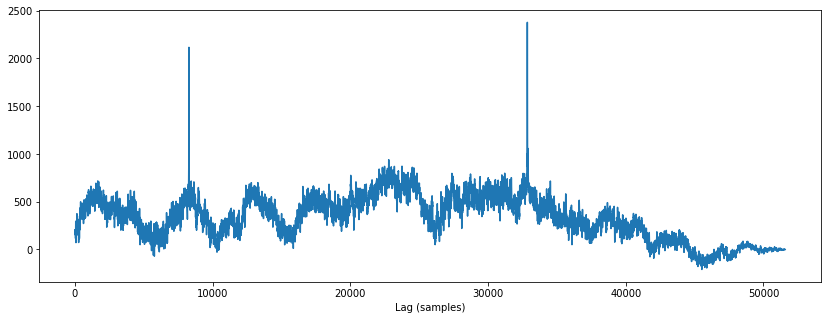

In [9]:

r = np.correlate(performances[performance[0]-1][:,feature], performances[performance[1]-1][:,feature], mode='full')[len(performances[performance[0]-1][:,feature])-1:]
plt.figure(figsize=(14, 5))
plt.plot(r)
plt.xlabel('Lag (samples)')

## vocal occurrence in performances

In [10]:
occurrence = pd.DataFrame({"female": [np.count_nonzero(label == 1)/len(label) for label in female_labels],
              "male": [np.count_nonzero(label == 1)/len(label) for label in male_labels],
              "choral": [np.count_nonzero(label == 1)/len(label) for label in choral_labels]})
occurrence

,female,male,choral
0,0.234477,0.461160,0.047600
1,0.466071,0.347164,0.177016
2,0.347097,0.321811,0.035420
3,0.267632,0.192060,0.252872
4,0.425782,0.149432,0.006077
5,0.251236,0.329090,0.007891
6,0.243338,0.488332,0.000000
7,0.322233,0.494133,0.047386
8,0.323976,0.505186,0.015975
9,0.334189,0.502794,0.016007


## difference between multiple annotations

In [31]:
def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: firebrick' if v else '' for v in is_max]

difference = pd.DataFrame({
 "file": [ index+1 for index, label in enumerate(label_list) if len(label['female'][0]) == 2],
 "female": [np.count_nonzero(abs(label['female'][:,0]-label['female'][:,1]))/len(label['female'][:,0])*100 for label in label_list if len(label['female'][0]) == 2],
 "male": [np.count_nonzero(abs(label['male'][:,0]-label['male'][:,1]))/len(label['male'][:,0])*100 for label in label_list if len(label['female'][0]) == 2],
 "choral": [np.count_nonzero(abs(label['choral'][:,0]-label['choral'][:,1]))/len(label['choral'][:,0])*100 for label in label_list if len(label['female'][0]) == 2]})

difference.style.apply(highlight_max, subset=['female','male', 'choral'])
#difference.style.background_gradient(cmap='OrRd', subset=['female','male', 'choral'])

,file,female,male,choral
0,6,1.475946,1.270434,3.007940
1,11,6.582507,10.769033,0.000000
2,12,3.013470,8.693237,1.138731
3,13,3.024164,3.226740,0.000000
4,14,6.397096,6.447171,24.323986
5,15,2.696045,6.199535,0.000000
6,16,4.620181,4.124150,5.286281
7,17,4.253984,13.615259,2.421885
8,19,4.935533,6.543740,0.000000
9,20,3.456188,9.206941,4.517424
